In [121]:
import pandas as pd
import os
from sklearn.impute import KNNImputer
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')
part = pd.read_csv("sub_ids/banda_id.csv")

In [3]:
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})

In [ ]:
particpant_info = pd.merge(banda_key, part, left_on='id', right_on='part', how='right').drop('part', axis=1)

In [5]:
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [6]:
def nn(score):
    return KNNImputer(
    missing_values=np.nan, 
    weights="uniform"
    ).fit_transform(score)

## Revised Child Anxiety and Depression Scale

In [7]:
sub_scores = {
    "social_phobia": [4, 7, 8, 12, 20, 30, 32, 38, 43],
    "panic_disorder": [3, 14, 24, 26, 28, 34, 36, 39, 41],
    "maj_depression": [2, 6, 11, 15, 19, 21, 25, 29, 40, 47],
    "seperation_anxiety": [5, 9, 17, 18, 33, 45, 46],
    "general_anxiety": [1, 13, 22, 27, 35, 37],
    "ocd": [10, 16, 23, 31, 42, 44]
}

rdacs_score = {
    "Never": 0,
    "Sometimes": 1,
    "Often": 2,
    "Always": 3
}
rcads01 = banda_df["rcads01"][banda_df["rcads01"]['visit'] == 'T1']
rcads01 = rcads01.drop(rcads01[rcads01['src_subject_id'].duplicated()].index)
rcads_cols = rcads01.columns[8:]
scored_df = rcads01[rcads_cols].replace(rdacs_score)
scores = dict(zip([key for key in sub_scores], [[] for key in sub_scores]))
scores['particpant'] = rcads01['src_subject_id'].loc[1:]

for sub_scal in sub_scores:
    scores[sub_scal] = scored_df.loc[:, [f"rcads_{str(index)}" for index in sub_scores[sub_scal]]].sum(axis=1)

rcads_df = pd.DataFrame(
    data = scores
)
cols = rcads_df.columns.tolist()
cols = [cols[-1]] + cols[1:-1] + [cols[0]]
cols = cols[:1] + [cols[2]] + [cols[1]] + cols[3:]
rcads_df = rcads_df[cols]

try:
    del(rcads_df['internalising'])
    del(rcads_df['anxiety'])
except Exception as e:
    pass
rcads_df['internalising'] = rcads_df.iloc[:, 1:].sum(axis=1)
rcads_df['anxiety'] = rcads_df.iloc[:, 2:7].sum(axis=1)
rcads_df = rcads_df.rename(columns={"particpant": "id"})

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_9195/3019860684.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scored_df = rcads01[rcads_cols].replace(rdacs_score)


In [8]:
rcads_df

,id,maj_depression,panic_disorder,seperation_anxiety,general_anxiety,ocd,social_phobia,internalising,anxiety
1,BANDA001,3.0,1.0,2.0,2.0,0.0,19.0,27.0,24.0
2,BANDA002,2.0,4.0,0.0,1.0,1.0,8.0,16.0,14.0
3,BANDA003,1.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0
4,BANDA004,7.0,2.0,0.0,1.0,3.0,11.0,24.0,17.0
5,BANDA005,3.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...
386,BANDA208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387,BANDA210,5.0,6.0,7.0,5.0,1.0,11.0,35.0,30.0
388,BANDA211,16.0,9.0,3.0,9.0,2.0,15.0,54.0,38.0
389,BANDA212,22.0,11.0,10.0,14.0,9.0,23.0,89.0,67.0


## Mood and Feelings Questionnaire

In [9]:
mfq01 = banda_df["mfq01"][banda_df["mfq01"]['visit'] == 'T1']
mfq01 = mfq01.drop(mfq01[mfq01['src_subject_id'].duplicated()].index)
mfq01 = pd.merge(mfq01.drop(["collection_id", "mfq01_id", "dataset_id", "subjectkey"], axis=1), particpant_info, left_on='src_subject_id', right_on='id')
mfq01 = mfq01.drop(["visit", "respondent", "collection_title", "Study", "id"], axis=1)

In [10]:
mfq_cols = mfq01.columns[4: 37]
transformed_data = {}
groups = mfq01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = nn(group[mfq_cols])
    dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)


mfg_score = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
mfg_score = mfg_score.rename(columns={"src_subject_id": "id", 0: "mfg_score"}).sort_values(by='id')

Anxiety
Control
Depression


## Snaith-Hamilton Pleasure Scale

In [273]:
class HCP_DataProcessor:
    def __init__(
            self, 
            df: pd.DataFrame, 
            participant_info: pd.DataFrame,
            scoring_metric: str) -> None:
        """
        Initialize the processor to process 
        some hcp behavioural data. 
    
        Parameters
        ------------
        df: pd.DataFrame: 
            Input dataframe.
        participant_info: pd.DataFrame: 
            Additional participant information.
        
        Returns
        -------
        None
            
        """
        self.df = df
        self.participant_info = participant_info
        self.scoring_metric = scoring_metric


    def preprocess_hcp_data(self):
        """
        Preprocess the SHAPS data by filtering, merging, and dropping unnecessary columns.
        """
        df = self.df[self.df['visit'] == 'T1']
        df = df.drop(df[df['src_subject_id'].duplicated()].index)
        df = pd.merge(
            df.drop(["collection_id", 
                     f"{self.scoring_metric}_id", 
                     "dataset_id", 
                     "subjectkey"], axis=1),
            self.participant_info,
            left_on='src_subject_id',
            right_on='id'
        )
        df = df.drop(["visit", "respondent", "collection_title", "Study", "id"], axis=1)
        return df
    
    def nn(self, score: np.array):
        """
        Nearest neighbours imputation
        """
        return KNNImputer(
            missing_values=np.nan, 
            weights="uniform"
            ).fit_transform(score)

    def transform_groups(
            self, 
            processed_df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply transformations to grouped data and compute scores.

        Args:
            df pd.DataFrame): Preprocessed SHAPS data.

        Returns:
            pd.DataFrame: Transformed and aggregated SHAPS scores.
        """
        df_cols = processed_df.columns[4:18]
        transformed_data = {}
        groups = processed_df.groupby("phenotype")

        for group_id, group in groups:
            transformed = nn(group[df_cols])
            dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
            transformed_data[group_id] = pd.concat([
                group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
                dataframe.reset_index(drop=True)], axis=1)

        df_score = pd.concat(transformed_data.values()).sort_values("src_subject_id")
        df_score = df_score.rename(
            columns={
                "src_subject_id": "id", 
                }).sort_values(by='id')
        return df_score

    def process(self):
        """
        Execute the entire SHAPS data processing workflow.

        Returns:
            pd.DataFrame: Final SHAPS scores.
        """
        hcp_df = self.preprocess_hcp_data()
        return self.transform_groups(hcp_df)

In [274]:
shaps01 = HCP_DataProcessor(banda_df["shaps01"], particpant_info, "shaps01")
shaps01_score = shaps01.process()
stai01_t = HCP_DataProcessor(banda_df["stai01"], particpant_info, "stai01")
stai01_t_score = stai01_t.process()

In [275]:
stai01_score.head()

,id,phenotype,state_val,trait_val
0,BANDA001,Control,42.0,47.0
1,BANDA002,Control,46.0,41.0
2,BANDA003,Control,49.0,44.0
3,BANDA004,Control,47.0,45.0
4,BANDA005,Control,42.0,33.0


In [276]:
stai01_t_score.head()

,id,phenotype,0
0,BANDA001,Control,33.0
1,BANDA002,Control,38.0
2,BANDA003,Control,38.0
3,BANDA004,Control,37.0
4,BANDA005,Control,32.0


In [229]:
shaps01 = banda_df["shaps01"][banda_df["shaps01"]['visit'] == 'T1']
shaps01 = shaps01.drop(shaps01[shaps01['src_subject_id'].duplicated()].index)
shaps01 = pd.merge(shaps01.drop(["collection_id", "shaps01_id", "dataset_id", "subjectkey"], axis=1), particpant_info, left_on='src_subject_id', right_on='id')
shaps01 = shaps01.drop(["visit", "respondent", "collection_title", "Study", "id"], axis=1)
shaps_cols = shaps01.columns[4: 18]
transformed_data = {}
groups = shaps01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = nn(group[shaps_cols])
    dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
shaps01_score = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
shaps01_score = shaps01_score.rename(columns={"src_subject_id": "id", 0: "shaps_score"}).sort_values(by='id')

Anxiety
Control
Depression


## State-Trait Anxiety Inventory (STAI)

In [12]:
state_cols = [col for col in banda_df["stai01"].columns if "Right now" in str(banda_df["stai01"].loc[0, col])]
trait_cols = [col for col in banda_df["stai01"].columns if "Generally" in str(banda_df["stai01"].loc[0, col])]

In [13]:
stai01 = banda_df["stai01"][banda_df["stai01"]['visit'] == 'T1']
stai01 = stai01.drop(stai01[stai01['src_subject_id'].duplicated()].index)
stai01 = pd.merge(stai01.drop(["collection_id", "stai01_id", "dataset_id", "subjectkey"], axis=1), particpant_info, left_on='src_subject_id', right_on='id')
stai01 = stai01.drop(["visit", "respondent", "collection_title", "Study", "id"], axis=1)

In [14]:
transformed_data = {}
groups = stai01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = nn(group[state_cols])
    dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
stai01_state = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
stai01_state = stai01_state.rename(columns={"src_subject_id": "id", 0: "state_val"}).sort_values(by='id')

Anxiety
Control
Depression


In [15]:
transformed_data = {}
groups = stai01.groupby("phenotype")
for group_id in groups.groups.keys():
    group = groups.get_group(group_id)
    print(group_id)
    transformed = nn(group[trait_cols])
    dataframe = pd.DataFrame(np.round(transformed)).sum(axis=1)
    transformed_data[group_id] = pd.concat([group[['src_subject_id', "phenotype"]].reset_index(drop=True), 
         dataframe.reset_index(drop=True)], axis=1)
stai01_trait = pd.concat([transformed_data['Control'], transformed_data['Anxiety'], transformed_data['Depression']]).sort_values("src_subject_id")
stai01_trait = stai01_trait.rename(columns={"src_subject_id": "id", 0: "trait_val"}).sort_values(by='id')

Anxiety
Control
Depression


In [16]:
stai01_score = pd.concat([stai01_state, stai01_trait['trait_val']], axis=1)
stai01_score

,id,phenotype,state_val,trait_val
0,BANDA001,Control,42.0,47.0
1,BANDA002,Control,46.0,41.0
2,BANDA003,Control,49.0,44.0
3,BANDA004,Control,47.0,45.0
4,BANDA005,Control,42.0,33.0
...,...,...,...,...
75,BANDA210,Anxiety,54.0,52.0
59,BANDA211,Depression,56.0,60.0
60,BANDA212,Depression,61.0,67.0
61,BANDA213,Depression,56.0,65.0


## Overall df

In [17]:
stai01_score

,id,phenotype,state_val,trait_val
0,BANDA001,Control,42.0,47.0
1,BANDA002,Control,46.0,41.0
2,BANDA003,Control,49.0,44.0
3,BANDA004,Control,47.0,45.0
4,BANDA005,Control,42.0,33.0
...,...,...,...,...
75,BANDA210,Anxiety,54.0,52.0
59,BANDA211,Depression,56.0,60.0
60,BANDA212,Depression,61.0,67.0
61,BANDA213,Depression,56.0,65.0


In [18]:
print(stai01_score.shape)
print(shaps01_score.shape)
print(mfg_score.shape)
print(rcads_df.shape)

(202, 4)
(201, 3)
(202, 3)
(201, 9)


In [19]:
rcads_df

,id,maj_depression,panic_disorder,seperation_anxiety,general_anxiety,ocd,social_phobia,internalising,anxiety
1,BANDA001,3.0,1.0,2.0,2.0,0.0,19.0,27.0,24.0
2,BANDA002,2.0,4.0,0.0,1.0,1.0,8.0,16.0,14.0
3,BANDA003,1.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0
4,BANDA004,7.0,2.0,0.0,1.0,3.0,11.0,24.0,17.0
5,BANDA005,3.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...
386,BANDA208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
387,BANDA210,5.0,6.0,7.0,5.0,1.0,11.0,35.0,30.0
388,BANDA211,16.0,9.0,3.0,9.0,2.0,15.0,54.0,38.0
389,BANDA212,22.0,11.0,10.0,14.0,9.0,23.0,89.0,67.0


In [87]:
from functools import reduce

dfs = [stai01_score[['id', 'state_val', 'trait_val']], 
       shaps01_score[['id', 'shaps_score']], 
       mfg_score[['id','mfg_score']], 
       rcads_df[['id', 'internalising']]]  # list of DataFrames
merged_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), dfs)
try:
    del banda_df_scored
except Exception:
    pass
banda_df_scored = pd.merge(particpant_info, merged_df, how='outer')

In [88]:
grouping = banda_df_scored.groupby("phenotype")
try:
     del(transformed_final)
except Exception:
     pass
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].mean(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df

In [89]:
banda_df_scored = pd.concat([transformed_final['Control'], transformed_final['Anxiety'], transformed_final['Depression']]).sort_values("id")

In [90]:
banda_df_scored

,id,phenotype,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising
0,BANDA001,Control,F,184,42.0,47.0,38.000000,37.0,27.000000
1,BANDA002,Control,F,169,46.0,41.0,38.000000,39.0,16.000000
2,BANDA003,Control,M,177,49.0,44.0,36.000000,33.0,4.000000
3,BANDA004,Control,M,188,47.0,45.0,32.000000,37.0,24.000000
4,BANDA005,Control,M,191,42.0,33.0,36.000000,33.0,4.000000
...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,54.0,52.0,55.000000,38.0,35.000000
199,BANDA211,Depression,F,196,56.0,60.0,52.000000,79.0,54.000000
200,BANDA212,Depression,F,186,61.0,67.0,52.000000,80.0,89.000000
201,BANDA213,Depression,F,184,56.0,65.0,51.000000,77.0,92.000000


In [108]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA

In [125]:
anxiety = banda_df_scored[['state_val', 'trait_val', 'internalising', 'shaps_score']]
depression = banda_df_scored[['mfg_score', 'shaps_score', 'internalising']]

In [146]:
features_from_fa = {}

for idx, phenotype in enumerate([anxiety, depression]):
    scaled_data = StandardScaler().fit_transform(phenotype)
    fa = FactorAnalysis(rotation='varimax', svd_method="lapack")
    features_from_fa[idx] = fa.fit_transform(scaled_data)

In [199]:
anxiety_fa = pd.DataFrame(features_from_fa[0])
anxiety_fa = anxiety_fa.loc[:, ~(anxiety_fa == 0).all()]
anxiety_fa.columns = [
    f"anxiety_fa_{col}" for col in anxiety_fa.columns
]
anxiety_fa

,anxiety_fa_0,anxiety_fa_1
0,-0.172782,0.096497
1,-0.733879,0.265555
2,-0.744594,0.404958
3,-0.376235,-0.082638
4,-1.422232,-0.207223
...,...,...
198,0.286364,2.100952
199,1.074434,2.055446
200,2.049463,2.308898
201,1.979688,1.894630


In [195]:
depression_fa = pd.DataFrame(features_from_fa[1])
depression_fa = depression_fa.loc[:, ~(depression_fa == 0).all()]
depression_fa.columns = [
    f"depression_fa_{col}" for col in depression_fa.columns
]
depression_fa

,depression_fa_0,depression_fa_1
0,-0.574405,-0.022887
1,-0.697216,-0.024537
2,-1.073720,0.017007
3,-0.670723,0.094699
4,-1.073720,0.017007
...,...,...
198,-0.281909,-0.356577
199,1.137681,-0.317070
200,1.732404,-0.315500
201,1.689959,-0.294195


In [200]:
try:
    del(banda)
except Exception:
    pass
banda = pd.concat([banda_df_scored, depression_fa, anxiety_fa], axis=1)

In [201]:
banda

,id,phenotype,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1
0,BANDA001,Control,F,184,42.0,47.0,38.000000,37.0,27.000000,-0.574405,-0.022887,-0.172782,0.096497
1,BANDA002,Control,F,169,46.0,41.0,38.000000,39.0,16.000000,-0.697216,-0.024537,-0.733879,0.265555
2,BANDA003,Control,M,177,49.0,44.0,36.000000,33.0,4.000000,-1.073720,0.017007,-0.744594,0.404958
3,BANDA004,Control,M,188,47.0,45.0,32.000000,37.0,24.000000,-0.670723,0.094699,-0.376235,-0.082638
4,BANDA005,Control,M,191,42.0,33.0,36.000000,33.0,4.000000,-1.073720,0.017007,-1.422232,-0.207223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,54.0,52.0,55.000000,38.0,35.000000,-0.281909,-0.356577,0.286364,2.100952
199,BANDA211,Depression,F,196,56.0,60.0,52.000000,79.0,54.000000,1.137681,-0.317070,1.074434,2.055446
200,BANDA212,Depression,F,186,61.0,67.0,52.000000,80.0,89.000000,1.732404,-0.315500,2.049463,2.308898
201,BANDA213,Depression,F,184,56.0,65.0,51.000000,77.0,92.000000,1.689959,-0.294195,1.979688,1.894630


<Axes: >

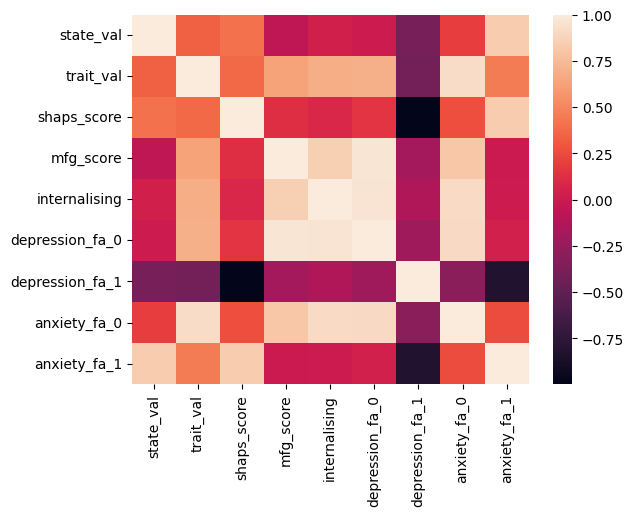

In [202]:
import seaborn as sns

sns.heatmap(
    banda[banda.columns[4:]].corr())

In [203]:
banda

,id,phenotype,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1
0,BANDA001,Control,F,184,42.0,47.0,38.000000,37.0,27.000000,-0.574405,-0.022887,-0.172782,0.096497
1,BANDA002,Control,F,169,46.0,41.0,38.000000,39.0,16.000000,-0.697216,-0.024537,-0.733879,0.265555
2,BANDA003,Control,M,177,49.0,44.0,36.000000,33.0,4.000000,-1.073720,0.017007,-0.744594,0.404958
3,BANDA004,Control,M,188,47.0,45.0,32.000000,37.0,24.000000,-0.670723,0.094699,-0.376235,-0.082638
4,BANDA005,Control,M,191,42.0,33.0,36.000000,33.0,4.000000,-1.073720,0.017007,-1.422232,-0.207223
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,M,193,54.0,52.0,55.000000,38.0,35.000000,-0.281909,-0.356577,0.286364,2.100952
199,BANDA211,Depression,F,196,56.0,60.0,52.000000,79.0,54.000000,1.137681,-0.317070,1.074434,2.055446
200,BANDA212,Depression,F,186,61.0,67.0,52.000000,80.0,89.000000,1.732404,-0.315500,2.049463,2.308898
201,BANDA213,Depression,F,184,56.0,65.0,51.000000,77.0,92.000000,1.689959,-0.294195,1.979688,1.894630


In [210]:
cols_to_correlate = banda_df_scored.columns[4:]
for col in cols_to_correlate:
    print(col)
    print('component anxiety:', pearsonr(banda["anxiety_fa_0"], banda[col])[0])
    print('component anxiety 1:', pearsonr(banda["anxiety_fa_1"], banda[col])[0])
    print('component depression:', pearsonr(banda["depression_fa_0"], banda[col])[0])
    print('component depression 1:', pearsonr(banda["depression_fa_1"], banda[col])[0])
    print()

state_val
component anxiety: 0.18890167427555218
component anxiety 1: 0.832590920331486
component depression: 0.005092213027364843
component depression 1: -0.3957281638153285

trait_val
component anxiety: 0.9194466374103398
component anxiety 1: 0.4523193167033137
component depression: 0.69541868031647
component depression 1: -0.4098922436260745

shaps_score
component anxiety: 0.2633414041026064
component anxiety 1: 0.8285335968935009
component depression: 0.1565512435847364
component depression 1: -0.9978526289228816

mfg_score
component anxiety: 0.8064520927452006
component anxiety 1: -0.004145162452713667
component depression: 0.9615583729045589
component depression 1: -0.19009002380320417

internalising
component anxiety: 0.9140718644034417
component anxiety 1: 0.007219931609931195
component depression: 0.9587130209051403
component depression 1: -0.13476267955600957



## Nbridge

In [211]:
from data_functions import scaling, permutation_null_distro, get_crit_val, get_significant_components, get_explained_ratio

In [212]:
banda['sex'] = banda['sex'].apply(lambda x: 0 if x == 'F' else 1)
banda['interview_age'] = banda['interview_age'].astype('float')

In [213]:
banda[banda.columns[2:]].dtypes

sex                  int64
interview_age      float64
state_val          float64
trait_val          float64
shaps_score        float64
mfg_score          float64
internalising      float64
depression_fa_0    float64
depression_fa_1    float64
anxiety_fa_0       float64
anxiety_fa_1       float64
dtype: object

In [214]:
decomp = PCA()
banda.columns = banda.columns.astype(str)
scaled_data = scaling(banda[banda.columns[2:]])
alt = decomp.fit_transform(scaled_data)

In [215]:
null_distro = permutation_null_distro(banda[banda.columns[2:]], n_perms=5000)
crti_val = get_crit_val(len(decomp.explained_variance_ratio_), null_distro)
alt_val = get_explained_ratio(decomp, len(decomp.explained_variance_ratio_))

In [216]:
comp = get_significant_components(crti_val, alt_val)
print(f"Component(s) {comp} are sigifiniciant components")

Component(s) [0, 1] are sigifiniciant components


In [217]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaled_data = scaling(banda[banda.columns[2:]])
alt_pca = PCA(n_components=2).fit_transform(scaled_data.values)
cluster_range = range(2, 11)
for cluster_n in cluster_range:
    clusterer = KMeans(n_clusters=cluster_n, random_state=10)
    cluster_labels = clusterer.fit_predict(alt_pca)
    silhouette_avg = silhouette_score(alt_pca, cluster_labels)
    print("For n_clusters =", cluster_n, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.4293200282553579
For n_clusters = 3 The average silhouette_score is : 0.47171444117543665
For n_clusters = 4 The average silhouette_score is : 0.39270616108573314
For n_clusters = 5 The average silhouette_score is : 0.39820386813487013
For n_clusters = 6 The average silhouette_score is : 0.393120888886942
For n_clusters = 7 The average silhouette_score is : 0.3588630776740153
For n_clusters = 8 The average silhouette_score is : 0.3686672703288222
For n_clusters = 9 The average silhouette_score is : 0.37567375957236193
For n_clusters = 10 The average silhouette_score is : 0.38381218481849594


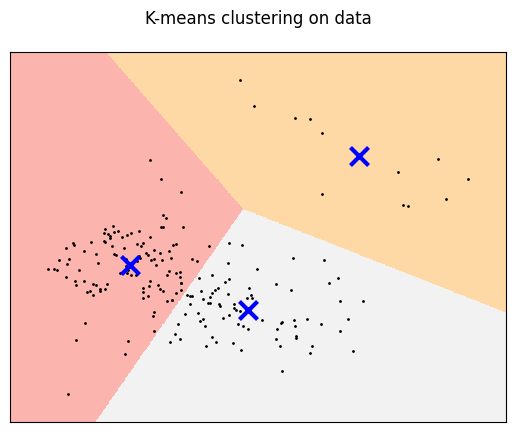

In [218]:
import matplotlib.pyplot as plt

reduced_data = alt_pca
n_digits = 3
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel1,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="b",
    zorder=10,
)
plt.title(
    "K-means clustering on data\n"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [219]:
banda['group'] = kmeans.labels_
banda

,id,phenotype,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1,group
0,BANDA001,Control,0,184.0,42.0,47.0,38.000000,37.0,27.000000,-0.574405,-0.022887,-0.172782,0.096497,0
1,BANDA002,Control,0,169.0,46.0,41.0,38.000000,39.0,16.000000,-0.697216,-0.024537,-0.733879,0.265555,0
2,BANDA003,Control,1,177.0,49.0,44.0,36.000000,33.0,4.000000,-1.073720,0.017007,-0.744594,0.404958,0
3,BANDA004,Control,1,188.0,47.0,45.0,32.000000,37.0,24.000000,-0.670723,0.094699,-0.376235,-0.082638,0
4,BANDA005,Control,1,191.0,42.0,33.0,36.000000,33.0,4.000000,-1.073720,0.017007,-1.422232,-0.207223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,BANDA210,Anxiety,1,193.0,54.0,52.0,55.000000,38.0,35.000000,-0.281909,-0.356577,0.286364,2.100952,1
199,BANDA211,Depression,0,196.0,56.0,60.0,52.000000,79.0,54.000000,1.137681,-0.317070,1.074434,2.055446,1
200,BANDA212,Depression,0,186.0,61.0,67.0,52.000000,80.0,89.000000,1.732404,-0.315500,2.049463,2.308898,1
201,BANDA213,Depression,0,184.0,56.0,65.0,51.000000,77.0,92.000000,1.689959,-0.294195,1.979688,1.894630,1


In [220]:
group = banda.groupby("group")
group_0 = group.get_group(0)
group_1 = group.get_group(1)
group_2 = group.get_group(2)

In [221]:
display(group_0['phenotype'].unique())
display(group_0[group_0.columns[2:]].describe())

array(['Control', 'Depression', 'Anxiety'], dtype=object)

,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1,group
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0
mean,0.456140,182.657895,42.885965,42.842105,35.350877,41.263158,20.517544,-0.582410,0.026593,-0.546662,-0.096249,0.0
std,0.500272,9.832967,5.798625,4.248017,3.312573,7.263745,13.748842,0.377936,0.065019,0.396729,0.468076,0.0
min,0.000000,168.000000,25.000000,29.000000,17.000000,33.000000,0.000000,-1.142635,-0.179384,-1.560820,-1.560435,0.0
25%,0.000000,174.250000,39.000000,40.000000,34.000000,35.250000,10.000000,-0.898948,0.009659,-0.816131,-0.422336,0.0
50%,0.000000,181.500000,44.000000,43.000000,35.000000,39.500000,19.000000,-0.612520,0.030404,-0.547734,-0.034649,0.0
75%,1.000000,189.000000,47.000000,45.000000,36.000000,45.000000,31.000000,-0.299415,0.052583,-0.315657,0.219088,0.0
max,1.000000,204.000000,58.000000,52.000000,46.000000,65.000000,61.000000,0.407233,0.391087,0.380662,1.154290,0.0


In [223]:
display(group_1['phenotype'].unique())
display(group_1[group_1.columns[2:]].describe())

array(['Control', 'Depression', 'Anxiety'], dtype=object)

,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1,group
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,0.416667,187.166667,55.416667,59.416667,52.166667,59.833333,50.416667,0.550068,-0.310971,0.983708,2.040236,1.0
std,0.514929,10.249908,4.033008,5.550730,3.040136,18.760855,29.675390,0.964747,0.055764,0.788631,0.300536,0.0
min,0.000000,169.000000,45.000000,51.000000,47.000000,33.000000,0.000000,-0.979473,-0.390751,-0.321766,1.297958,1.0
25%,0.000000,182.000000,54.000000,54.500000,50.750000,44.000000,31.500000,-0.224851,-0.347570,0.403120,1.875991,1.0
50%,0.000000,189.000000,56.000000,60.000000,52.500000,62.000000,51.500000,0.729148,-0.317127,1.046754,2.097279,1.0
75%,1.000000,193.750000,57.500000,63.500000,54.250000,77.500000,71.500000,1.312315,-0.286924,1.611316,2.243268,1.0
max,1.000000,203.000000,61.000000,67.000000,56.000000,80.000000,92.000000,1.732404,-0.214633,2.049463,2.381003,1.0


In [224]:
display(group_2['phenotype'].unique())
display(group_2[group_1.columns[2:]].describe())

array(['Depression', 'Anxiety'], dtype=object)

,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1,group
count,77.000000,77.000000,77.000000,77.00000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.0
mean,0.194805,188.610390,41.760997,51.25995,35.761995,65.191244,63.288283,0.776545,0.009091,0.656038,-0.175460,2.0
std,0.398648,9.787419,5.704289,4.59805,2.684285,12.697757,17.774193,0.572446,0.053748,0.460095,0.399290,0.0
min,0.000000,169.000000,28.000000,44.00000,30.000000,40.000000,32.000000,-0.104737,-0.177168,-0.070273,-1.007463,2.0
25%,0.000000,181.000000,38.000000,48.00000,34.000000,55.000000,51.000000,0.346567,-0.022365,0.312272,-0.449745,2.0
50%,0.000000,189.000000,42.000000,50.00000,36.000000,65.000000,58.145161,0.687762,0.012057,0.522299,-0.200484,2.0
75%,0.000000,198.000000,45.000000,55.00000,37.000000,76.000000,74.000000,1.170285,0.046043,1.005183,0.039793,2.0
max,1.000000,204.000000,55.000000,62.00000,45.000000,89.000000,119.000000,2.340471,0.134524,1.727748,0.756977,2.0


In [222]:
group_0.groupby("phenotype").count()

,id,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1,group
phenotype,,,,,,,,,,,,,
Anxiety,38,38,38,38,38,38,38,38,38,38,38,38,38
Control,62,62,62,62,62,62,62,62,62,62,62,62,62
Depression,14,14,14,14,14,14,14,14,14,14,14,14,14


In [226]:
plotting = pd.concat([group_0, group_1, group_2])
plotting

,id,phenotype,sex,interview_age,state_val,trait_val,shaps_score,mfg_score,internalising,depression_fa_0,depression_fa_1,anxiety_fa_0,anxiety_fa_1,group
0,BANDA001,Control,0,184.0,42.0,47.0,38.000000,37.0,27.000000,-0.574405,-0.022887,-0.172782,0.096497,0
1,BANDA002,Control,0,169.0,46.0,41.0,38.000000,39.0,16.000000,-0.697216,-0.024537,-0.733879,0.265555,0
2,BANDA003,Control,1,177.0,49.0,44.0,36.000000,33.0,4.000000,-1.073720,0.017007,-0.744594,0.404958,0
3,BANDA004,Control,1,188.0,47.0,45.0,32.000000,37.0,24.000000,-0.670723,0.094699,-0.376235,-0.082638,0
4,BANDA005,Control,1,191.0,42.0,33.0,36.000000,33.0,4.000000,-1.073720,0.017007,-1.422232,-0.207223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,BANDA192,Anxiety,0,180.0,41.0,54.0,38.000000,81.0,81.000000,1.519162,-0.041691,1.113662,-0.086593,2
184,BANDA193,Anxiety,0,191.0,41.0,58.0,35.000000,68.0,69.000000,0.940817,0.022980,1.171016,-0.174904,2
185,BANDA194,Depression,1,200.0,38.0,53.0,38.000000,89.0,60.000000,1.400534,-0.046933,0.731018,-0.177868,2
187,BANDA196,Depression,0,179.0,43.0,44.0,35.000000,71.0,87.000000,1.315525,0.022545,0.560879,-0.411849,2


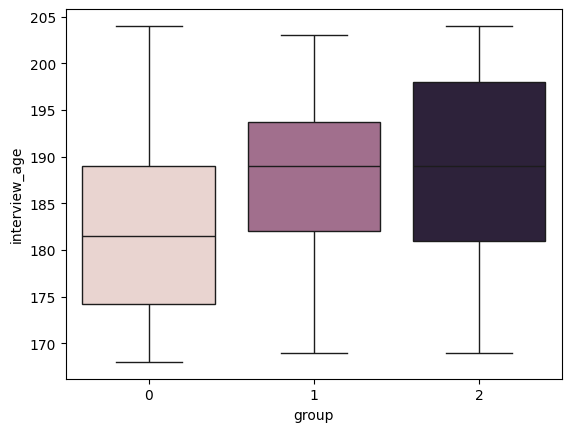

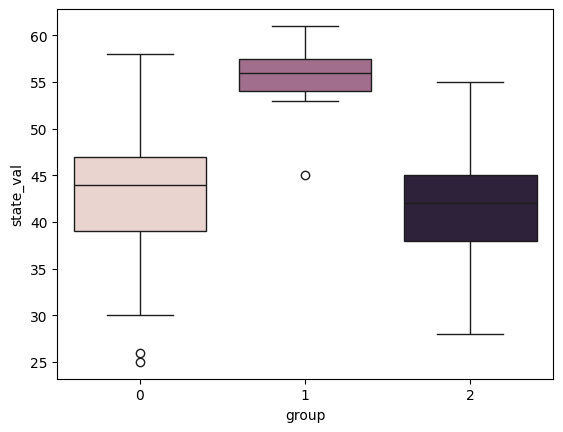

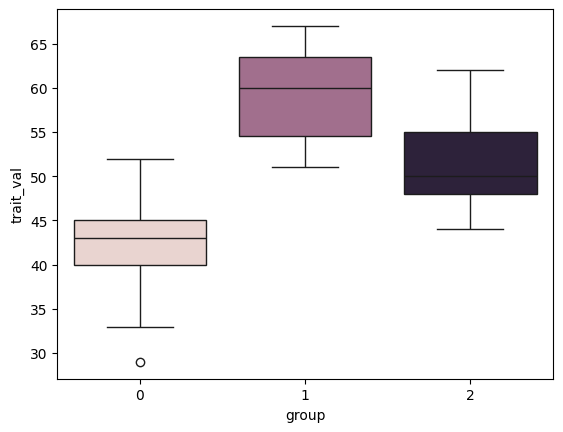

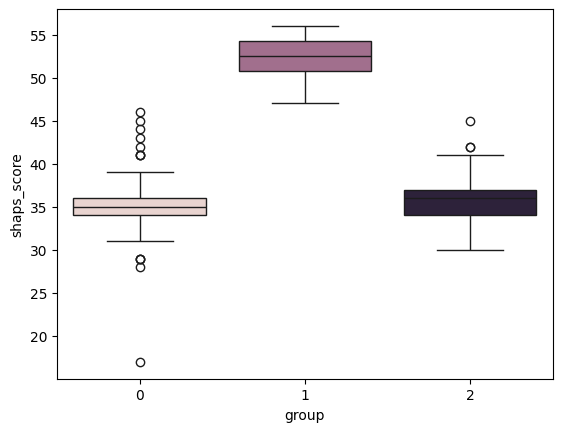

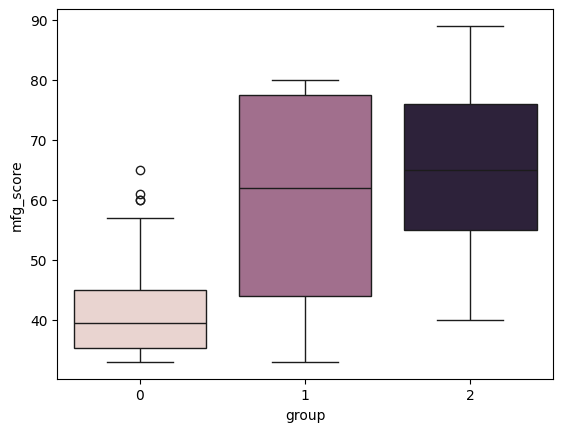

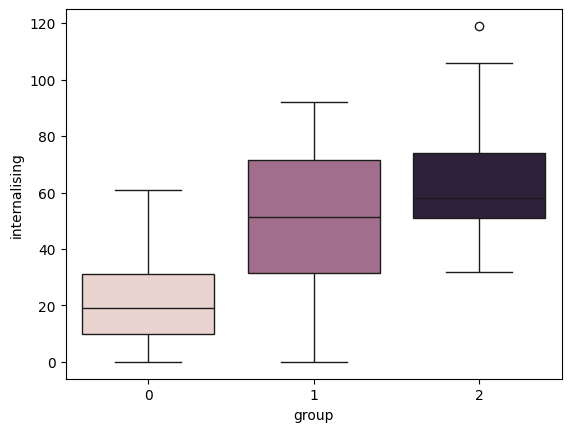

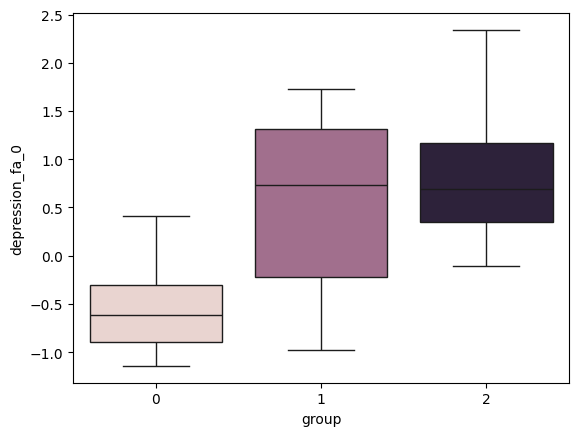

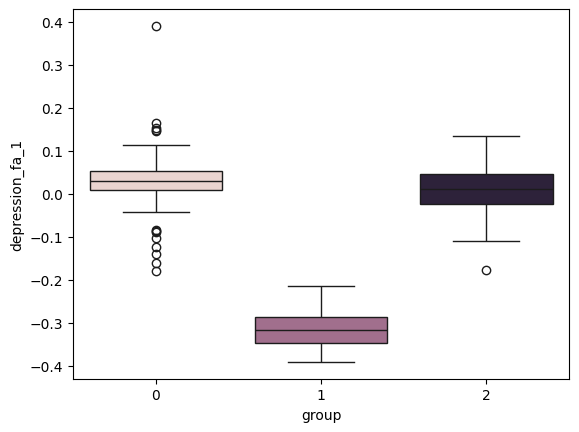

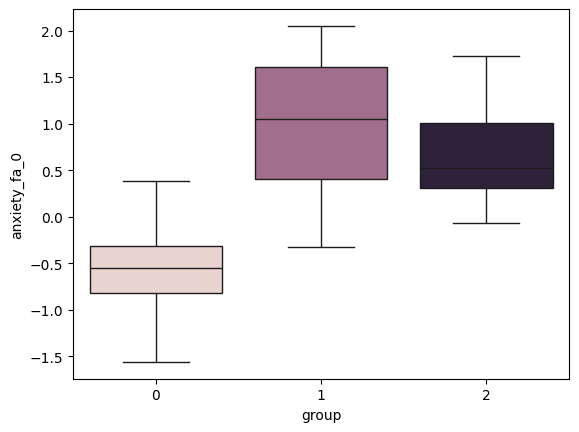

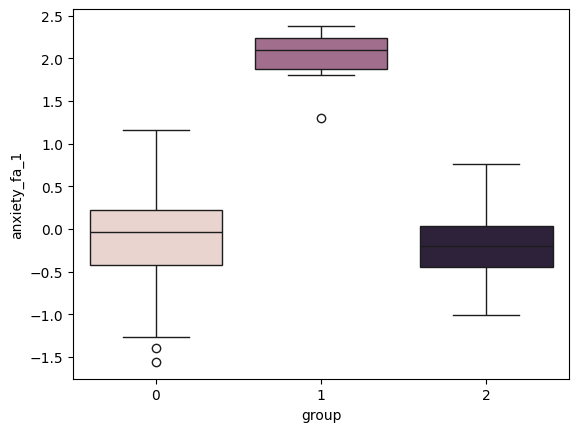

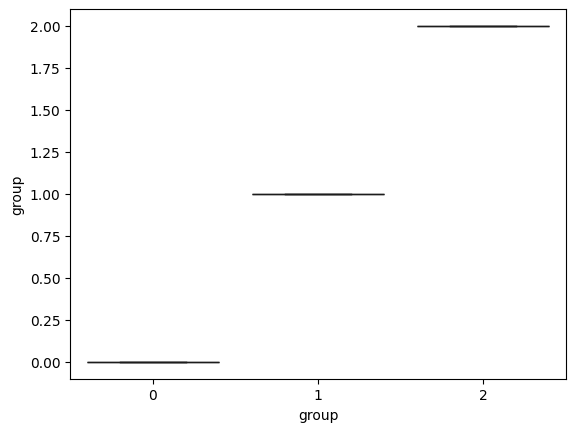

In [227]:
for val in plotting[plotting.columns[3:]]:
    plot = sns.boxplot(data=plotting, x='group', y=val, hue='group')
    plot.get_legend().remove()
    plt.show()